In [2]:
from __future__ import annotations
from dataclasses import dataclass
import numpy as np
from numba import njit
from numba.experimental import jitclass
from tqdm import tqdm

In [6]:
@njit
def grad2(x: np.array):
    m, n = x.shape
    y = np.zeros_like(x)
    for i in range(m):
        for j in range(n):
            y[i,j] = x[(i-1)%m,j] + x[i,(j-1)%n] \
                   + x[(i+1)%m,j] + x[i,(j+1)%n] - 4*x[i,j]
    return y


def euler_method(df, y_init, t_init, t_end, t_step):
    n_steps = int((t_end - t_init) / t_step)
    y = y_init
    times = (t_init + i*t_step for i in range(n_steps))
    return (y := y + df(y, t)*t_step for t in times)


def initial_state(shape) -> np.ndarray:
    U = np.ones(shape, dtype=np.float32)
    V = np.zeros(shape, dtype=np.float32)

    centre = (slice(shape[0]//2-10, shape[0]//2+10),
              slice(shape[1]//2-10, shape[1]//2+10))
    U[centre] = 1/2
    V[centre] = 1/4

    U += np.random.normal(0.0, 0.01, size=shape)
    V += np.random.normal(0.0, 0.01, size=shape)

    return np.stack((U, V))


def reaction_diffusion(F, k, D_u=2e-5, D_v=1e-5, res=0.01):
    def df(state: np.ndarray, _: float) -> np.ndarray:
        U, V = state
        du = D_u*grad2(U)/res**2 - U*V**2 + F*(1 - U)
        dv = D_v*grad2(V)/res**2 + U*V**2 - (F + k)*V
        return np.stack((du, dv))
    return df

In [11]:
def run_model(k, F, t_end=10_000, write_interval=20, shape=(256, 256)):
    n_snaps = t_end // write_interval
    result = np.zeros(shape=[n_snaps, 2, shape[0], shape[1]],
                      dtype=np.float32)

    rd = reaction_diffusion(k=k, F=F)
    init = initial_state(shape=shape)
    comp = euler_method(rd, init, 0, t_end, 1)
    for i, snap in tqdm(enumerate(comp), total=t_end):
        if i % write_interval == 0:
            result[i // write_interval] = snap
            
    np.save(f"k{int(k*10_000):04}-F{int(F*10_000):04}.npy", result)

In [12]:
run_model(0.06, 0.04)

100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 742.09it/s]


In [13]:
x = np.load("k0600-F0400.npy")

In [15]:
from matplotlib import pyplot as plt

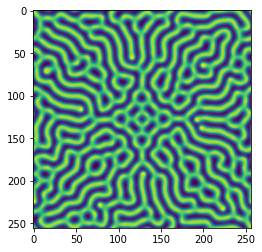

In [17]:
plt.imshow(x[-1][1])